# Etude de l'Oscillation de Madden-Julian (MJO)

Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2020

La MJO est le principal mode de variabilité de l'atmosphère tropicale à l'échelle intra saisonnière. Elle se caractérise par le lent déplacement vers l'est d'une structure d'échelle planétaire d'anomalie de convection profonde couplée à des anomalies de vent zonal en haute et basse troposphère.

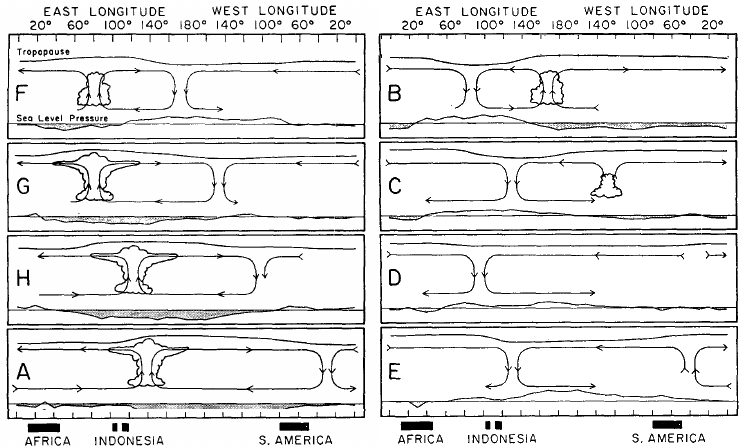

L'objectif de ce TP Python est de réaliser des composites par phases de la MJO à partir de l'indice en temps réel de la MJO (Realtime Multivariate MJO Index - Wheeler & Hendon, 2004) obtenu utilisant une méthode d'analyse en composantes principales (ACP) combinant OLR, U850 et U200 (http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt).

Concepts Python illustrés :

- Exploitation de fichiers au format netcdf (netCDF4, xarray)
- Calcul de climatologies et d'anomalies
- Tracé de cartes et d'animations (matplotlib, cartopy)
- Réalisation de cartes "composites" par phase MJO

In [1]:
%matplotlib inline

import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

In [2]:
dir_data='./data/'
dir_res='./result/'
dir_figs='./figs/'
dir_anim='./anim/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)
if not os.path.exists(dir_res):
    os.makedirs(dir_res)

# Ouverture des données

In [3]:
rmm=np.loadtxt(dir_res+'mjo_rmm_index.txt',skiprows=247, usecols = (0,1,2,3,4,5,6))
rmm_year=rmm[:,0]
rmm_month=rmm[:,1]
rmm_day=rmm[:,2]
rmm_phase=rmm[:,6]
rmm_amplitude=rmm[:,5]
rmm_phase=rmm_phase.flatten()
rmm_amplitude=rmm_amplitude.flatten()
print(rmm_year[0])
print(rmm_month[0])
print(rmm_day[0])
print(rmm_year[-1])
print(rmm_month[-1])
print(rmm_day[-1])
print(rmm_phase)

1981.0
1.0
1.0
2020.0
12.0
31.0
[0. 0. 0. ... 0. 0. 0.]


In [4]:
year1='1981'
year2='2020'
f    = xr.open_dataset(dir_data+'vp200.1980-2021.nc').sel(time=slice(year1,year2))
fo    = xr.open_dataset('./data/olr.day.mean.nc').sel(time=slice(year1,year2))
lat = f.lat.values
lon = f.lon.values
print(' ----- Computing daily anomalies ----- ')
f_anom=f.groupby('time.dayofyear') - f.groupby('time.dayofyear').mean('time')
fo_anom=fo.groupby('time.dayofyear') - fo.groupby('time.dayofyear').mean('time')
print(f_anom)
time  = f.time.values
lat = f.lat.values
print(time)
vp = f['VP200']
vp_anom = f_anom['VP200']
olr = fo['olr']
olr_anom = fo_anom['olr']
print(' ----- Done ----- ')

 ----- Computing daily anomalies ----- 
<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 14610)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    VP200      (time, lat, lon) float32 1242649.8 1242650.2 ... 159960.0
['1981-01-01T00:00:00.000000000' '1981-01-02T00:00:00.000000000'
 '1981-01-03T00:00:00.000000000' ... '2020-12-29T00:00:00.000000000'
 '2020-12-30T00:00:00.000000000' '2020-12-31T00:00:00.000000000']
 ----- Done ----- 


# Calcul des composites par phase MJO

In [5]:
months=[1,2,3,11,12]
months_txt="NDJFM"
#months=[5,6,7,8,9]
#months_txt="MJJAS"

In [6]:
# Construct logical array for season
season = np.any([rmm_month == months[0], rmm_month == months[1], rmm_month == months[2], rmm_month == months[3], rmm_month == months[4]], axis=0)

# Construct logical array for phases
phase0 = np.all([rmm_phase==0], axis=0)
phase1 = np.all([rmm_phase==1], axis=0)
phase2 = np.all([rmm_phase==2], axis=0)
phase3 = np.all([rmm_phase==3], axis=0)
phase4 = np.all([rmm_phase==4], axis=0)
phase5 = np.all([rmm_phase==5], axis=0)
phase6 = np.all([rmm_phase==6], axis=0)
phase7 = np.all([rmm_phase==7], axis=0)
phase8 = np.all([rmm_phase==8], axis=0)

#Intersection of conditions for season
p0=np.logical_and(season, phase0)[:]
p1=np.logical_and(season, phase1)[:]
p2=np.logical_and(season, phase2)[:]
p3=np.logical_and(season, phase3)[:]
p4=np.logical_and(season, phase4)[:]
p5=np.logical_and(season, phase5)[:]
p6=np.logical_and(season, phase6)[:]
p7=np.logical_and(season, phase7)[:]
p8=np.logical_and(season, phase8)[:]

# Select data for season and filtered by phase
vp_p0=vp_anom[p0,:,:]
vp_p1=vp_anom[p1,:,:]
vp_p2=vp_anom[p2,:,:]
vp_p3=vp_anom[p3,:,:]
vp_p4=vp_anom[p4,:,:]
vp_p5=vp_anom[p5,:,:]
vp_p6=vp_anom[p6,:,:]
vp_p7=vp_anom[p7,:,:]
vp_p8=vp_anom[p8,:,:]

olr_p0=olr_anom[p0,:,:]
olr_p1=olr_anom[p1,:,:]
olr_p2=olr_anom[p2,:,:]
olr_p3=olr_anom[p3,:,:]
olr_p4=olr_anom[p4,:,:]
olr_p5=olr_anom[p5,:,:]
olr_p6=olr_anom[p6,:,:]
olr_p7=olr_anom[p7,:,:]
olr_p8=olr_anom[p8,:,:]

# Number of days per phase

n0=len(vp_p0[:,0,0])
n1=len(vp_p1[:,0,0])
n2=len(vp_p2[:,0,0])
n3=len(vp_p3[:,0,0])
n4=len(vp_p4[:,0,0])
n5=len(vp_p5[:,0,0])
n6=len(vp_p6[:,0,0])
n7=len(vp_p7[:,0,0])
n8=len(vp_p8[:,0,0])

n=np.stack((n0, n1, n2, n3, n4, n5, n6, n7, n8))
print(n)

# Compute season composites for the 8 phases 

vp_composite0=vp_p0.mean(axis=0)
vp_composite1=vp_p1.mean(axis=0)
vp_composite2=vp_p2.mean(axis=0)
vp_composite3=vp_p3.mean(axis=0)
vp_composite4=vp_p4.mean(axis=0)
vp_composite5=vp_p5.mean(axis=0)
vp_composite6=vp_p6.mean(axis=0)
vp_composite7=vp_p7.mean(axis=0)
vp_composite8=vp_p8.mean(axis=0)

vp_composite = np.ones((9,len(lat),len(lon)))
vp_composite[0,:,:]=vp_composite0
vp_composite[1,:,:]=vp_composite1
vp_composite[2,:,:]=vp_composite2
vp_composite[3,:,:]=vp_composite3
vp_composite[4,:,:]=vp_composite4
vp_composite[5,:,:]=vp_composite5
vp_composite[6,:,:]=vp_composite6
vp_composite[7,:,:]=vp_composite7
vp_composite[8,:,:]=vp_composite8

olr_composite0=olr_p0.mean(axis=0)
olr_composite1=olr_p1.mean(axis=0)
olr_composite2=olr_p2.mean(axis=0)
olr_composite3=olr_p3.mean(axis=0)
olr_composite4=olr_p4.mean(axis=0)
olr_composite5=olr_p5.mean(axis=0)
olr_composite6=olr_p6.mean(axis=0)
olr_composite7=olr_p7.mean(axis=0)
olr_composite8=olr_p8.mean(axis=0)

olr_composite = np.ones((9,len(lat),len(lon)))
olr_composite[0,:,:]=olr_composite0
olr_composite[1,:,:]=olr_composite1
olr_composite[2,:,:]=olr_composite2
olr_composite[3,:,:]=olr_composite3
olr_composite[4,:,:]=olr_composite4
olr_composite[5,:,:]=olr_composite5
olr_composite[6,:,:]=olr_composite6
olr_composite[7,:,:]=olr_composite7
olr_composite[8,:,:]=olr_composite8

[2123  390  561  569  430  434  502  577  464]


# Tracés

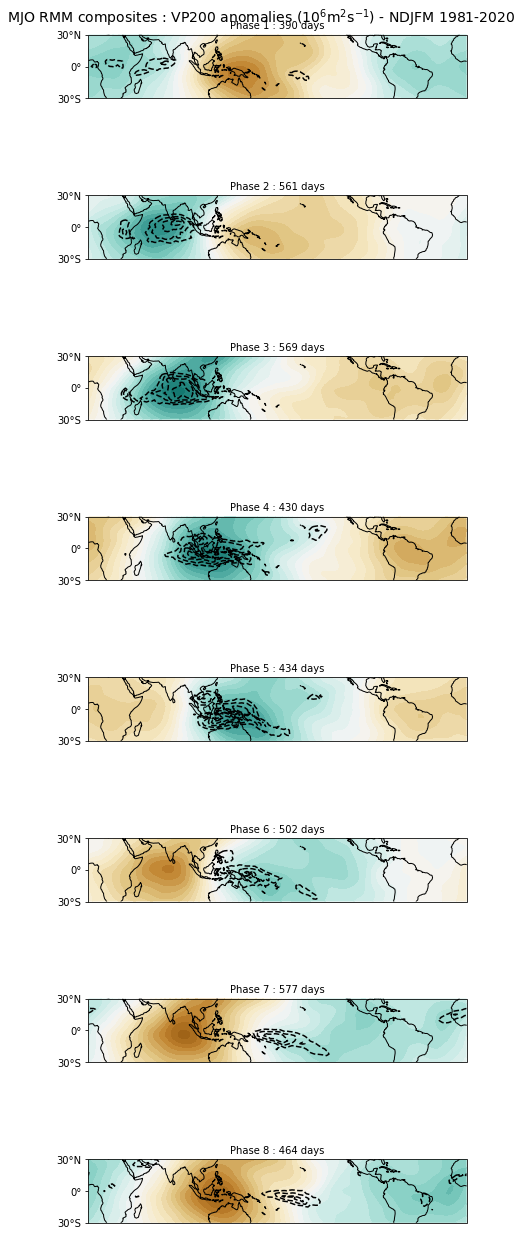

In [7]:
levels = np.arange(-10,10.5,0.5)
levels_o = np.arange(-35,-5, 5)

cmap='BrBG_r'
lonW=lon[0]
lonE=lon[-1]
latS=-30.
latN=30.
plt_title='MJO RMM composites : VP200 anomalies ($10^6$m$^2$s$^{-1}$) - '+months_txt+' '+year1+'-'+year2

bounds = [(lonW, lonE, latS, latN)]

def plot_background(ax):
   ax.set_yticks(np.linspace(latS, latN, 3), crs=ccrs.PlateCarree())
   lat_formatter = LatitudeFormatter()
   ax.yaxis.set_major_formatter(lat_formatter)
   ax.coastlines()
   ax.set_extent(*bounds, crs=ccrs.PlateCarree())
   return ax

fig = plt.figure(figsize=(6, 18))
fig.suptitle(plt_title, fontsize=14)

for i in range(1,9):
    ax = fig.add_subplot(8, 1, i, projection=ccrs.PlateCarree(central_longitude=180.0))
    plot_background(ax)
    ax.set_title('Phase '+str(i)+' : '+str(n[i])+' days', fontsize=10)
    c = ax.contour(lon, lat, olr_composite[i], levels_o, transform=ccrs.PlateCarree(), colors='black')
    cf = ax.contourf(lon, lat, vp_composite[i]*1e-06, levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')

#cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')

fig.tight_layout()

plt.show()

figname=dir_figs+'MJO_RMM_VP200_'+months_txt
fig.savefig(figname+'.png', bbox_inches = 'tight')

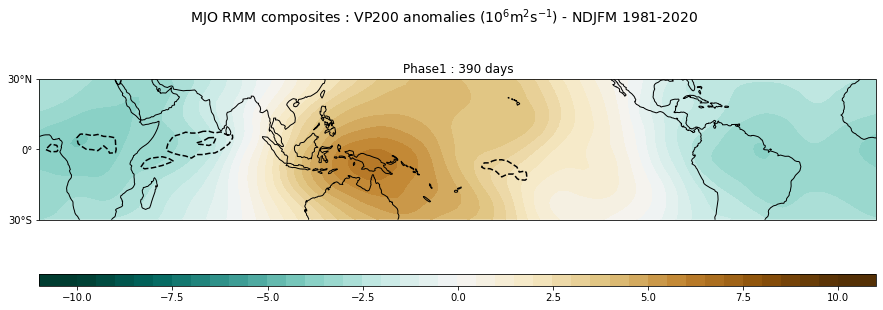

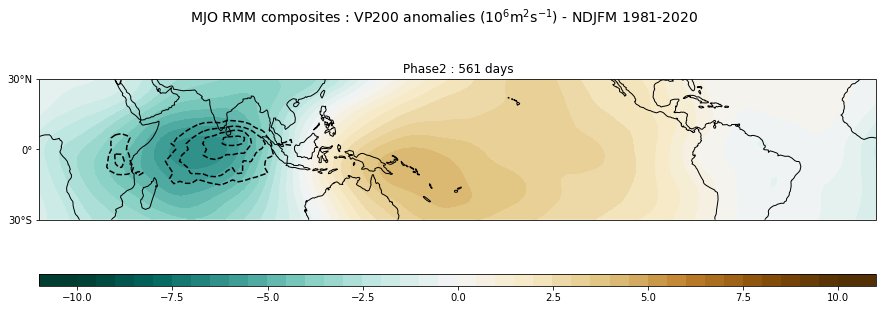

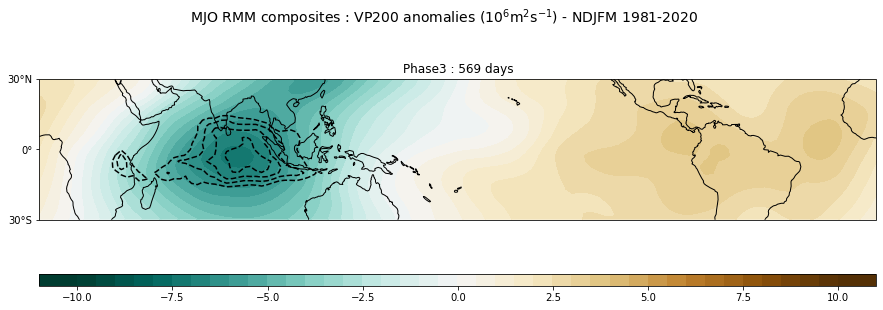

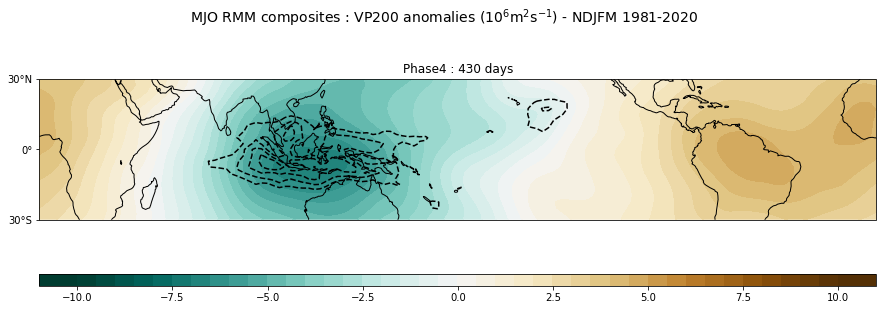

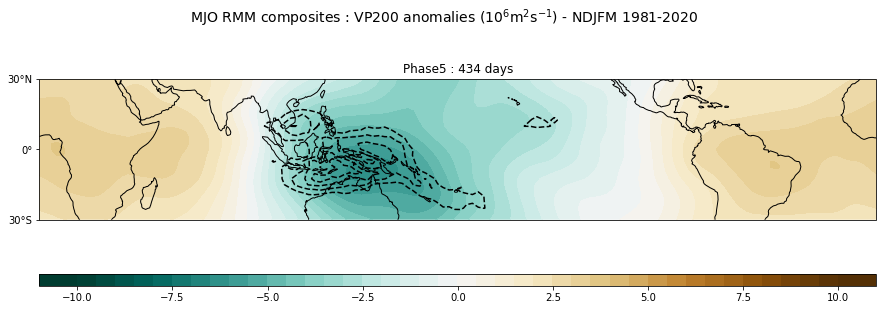

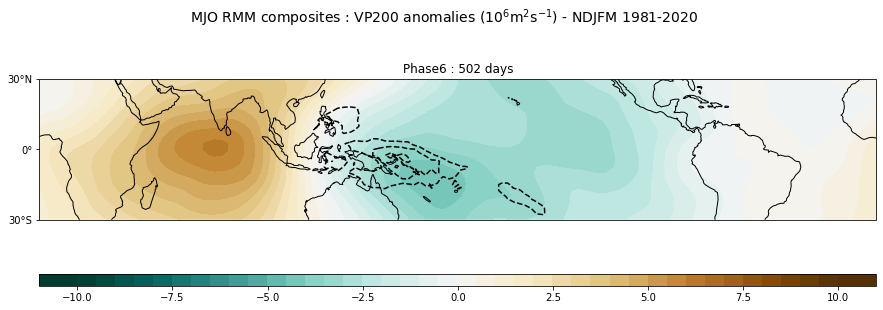

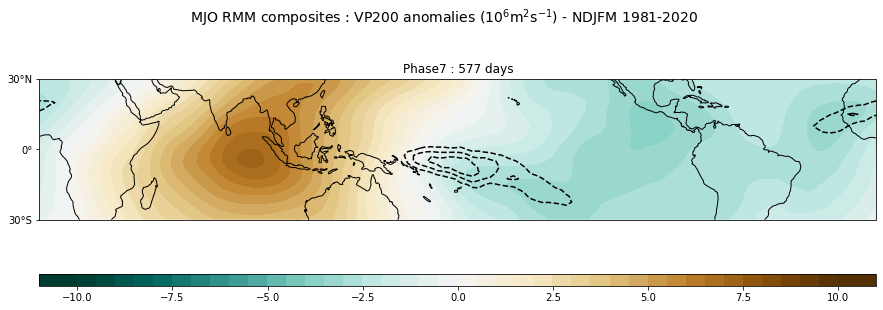

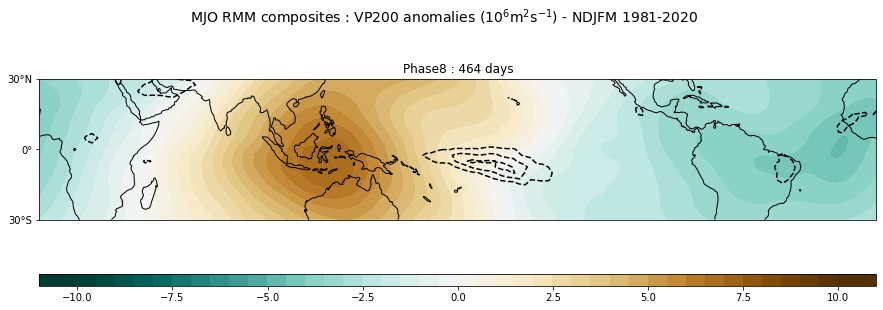

In [8]:
for i in range(1,9):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(plt_title, fontsize=14)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
    plot_background(ax)
    ax.set_title('Phase'+str(i)+' : '+str(n[i])+' days', fontsize=12)
    cf = ax.contourf(lon, lat, vp_composite[i]*1e-6, levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    c = ax.contour(lon, lat, olr_composite[i], levels_o, transform=ccrs.PlateCarree(), colors='black')    
    cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=1, pad=0.20, extendrect='True')
    plt.show()
    figname=dir_anim+'MJO_RMM_VP200_'+months_txt+'_'+str(i)
    fig.savefig(figname+'.png', bbox_inches = 'tight')

In [9]:
def make_animation():
    nbimages=8
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 100 ms
    standard_duration = 1000 #show all other frames for 5 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir(dir_anim)
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../")
    return Image

In [10]:
gif_filepath = dir_anim+'MJO_RMM_VP200_'+months_txt+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

# Pour aller plus loin

- Réaliser des composites par phase de la MJO pour les variables potentiel de vitesse à 200 hPa, Pression réduite au niveau de la mer, précipitations, fonction de courant à 200 hPa (données à demander à l'encadrant).

- Réaliser des composites par phase de la MJO des cyclogenèses/trajectoires de cyclones tropicaux (données à demander à l'encadrant).